In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import seaborn as sns

In [2]:
plt.set_cmap('coolwarm')

<Figure size 432x288 with 0 Axes>

In [3]:
np.set_printoptions(threshold=10, precision=6)
sigmoid = lambda x: 1 / (1 + np.exp(-x))

# Binary Classification

### Generating Bivariate Classification Data

In [4]:
def generate_bivariate_data(size, classes=2, angle=None, sep=1, noise=1.5):
    x_c = np.linspace(-sep, sep, classes) * classes
    y_c = np.random.permutation(x_c)
    X = np.concatenate([np.random.normal(loc=(x_c[i], y_c[i]), 
                                         scale=noise, 
                                         size=(size // classes, 2)) for i in range(classes)], axis=0)
    y = np.concatenate([np.zeros(size // classes) + i for i in range(classes)], axis=0)
    angle = angle if angle else np.random.randint(0, 181)
    theta = np.pi / 180 * angle
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    X = X @ R
    return X, y

In [5]:
X, y = generate_bivariate_data(500)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (400, 2)
X_test shape :  (100, 2)
y_train shape :  (400,)
y_test shape :  (100,)


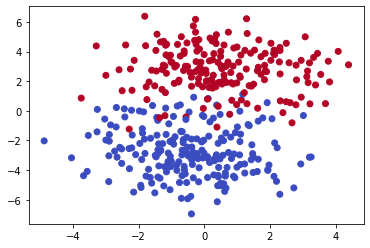

In [8]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Logistic Regression Model

In [9]:
class BinaryClassifier:
    def __init__(self, n_features, degree=1, weights=None, normalize=True, threshold=0.5):
        self.__n_features = n_features
        self.__degree = degree
        self.weights = weights if np.sum(weights) else np.random.randn(n_features * degree + 1) 
        self.__normalize = normalize
        self.__scaling_params = (0, 1)
        self.__threshold = threshold
        self.metrics = None
            
    def __transform(self, X, training=False, normalize=True):
        X_init = X
        for i in range(2, self.__degree + 1):
            X = np.c_[X, X_init ** i]
        if training:
            self.__scaling_params = (X.mean(axis=0), X.std(axis=0))
        if self.__normalize:
            mu, s = self.__scaling_params
            X = (X - mu) / (s + 1e-9)
        return np.c_[np.ones((X.shape[0], 1)), X].T  
    
    def fit(self, X, y, epochs=1, batch_size=None, alpha=0.001, verbose=True):
        X = self.__transform(X, training=True)
        loss_per_epochs, acc_per_epochs = [], []
        for i in range(epochs):
            y_pred = sigmoid(self.weights.T @ X)
            J = -np.mean(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
            acc = np.mean((y_pred >= self.__threshold) == y)
            loss_per_epochs.append(J)
            acc_per_epochs.append(acc)
            self.weights -= alpha * np.mean((y_pred - y) * X, axis=1)            
            if verbose:
                print(f'Epoch {i+1}/{epochs}\n{X.shape[-1]}/{X.shape[-1]} [==============] : loss = {J:.6f}\t acc = {acc}')
        self.metrics= {'loss_per_epochs' : loss_per_epochs, 'acc_per_epochs' : acc_per_epochs}
        
    def predict(self, X, predict_classes=False):
        y_pred = sigmoid(self.weights.T @ self.__transform(X))
        if predict_classes:
            y_pred = y_pred >= self.__threshold
        return y_pred
    
    def evaluate(self, X, y, return_preds=False):
        y_pred = self.predict(X)
        J = -np.mean(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
        acc = np.mean((y_pred >= self.__threshold) == y)
        evaluation = {'loss' : J, 'accurracy' : acc}
        if return_preds:
            evaluation['predictions'] = y_pred
        return evaluation
    
    def get_weights(self, return_scaling_params=False):
        """returns weights as a dict object with keys - `weights` and `bias`"""
        model_weights = {'weights' : self.weights[1:], 'bias' : self.weights[0]}
        if return_scaling_params:
            model_weights['scaling_mean'], model_weights['scaling_std'] = self.__scaling_params
        return model_weights 
    
    def plot_decision_boundary(self, X, y, figsize=(7,7), ec='white', s=50,alpha=0.8):
        plt.figure(figsize=figsize)
        x1 = np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, 0.1)
        x2 = np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, 0.1)

        X1, X2 = np.meshgrid(x1, x2)
        X1, X2 = X1.ravel(), X2.ravel() 
        preds = model.predict(np.c_[X1, X2]).reshape(x2.shape[0], x1.shape[0])

        extent=[X[:, 0].min() - 1, X[:, 0].max() + 1, X[:, 1].min() - 1, X[:, 1].max() + 1]
        plt.imshow(preds, origin='lower', extent=extent, alpha=alpha, aspect='auto')
        plt.scatter(X[:, 0], X[:, 1], c=y, ec=ec, s=s)

### Training

In [10]:
model = BinaryClassifier(n_features=2)

In [11]:
model.fit(X_train, y_train, epochs=10, alpha=1)

Epoch 1/10
400/400 [==============] : loss = 0.573463	 acc = 0.705
Epoch 2/10
400/400 [==============] : loss = 0.471350	 acc = 0.7925
Epoch 3/10
400/400 [==============] : loss = 0.398882	 acc = 0.83
Epoch 4/10
400/400 [==============] : loss = 0.346893	 acc = 0.8625
Epoch 5/10
400/400 [==============] : loss = 0.308894	 acc = 0.8975
Epoch 6/10
400/400 [==============] : loss = 0.280474	 acc = 0.905
Epoch 7/10
400/400 [==============] : loss = 0.258697	 acc = 0.925
Epoch 8/10
400/400 [==============] : loss = 0.241612	 acc = 0.93
Epoch 9/10
400/400 [==============] : loss = 0.227916	 acc = 0.9425
Epoch 10/10
400/400 [==============] : loss = 0.216719	 acc = 0.9425


Text(0.5, 1.0, 'Training Accuracy')

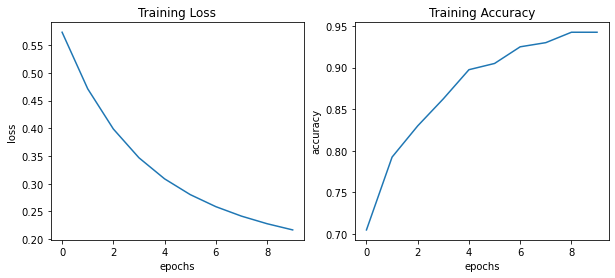

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(model.metrics['loss_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.subplot(122)
plt.plot(model.metrics['acc_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')

In [13]:
min(model.metrics['loss_per_epochs'])

0.21671916437223054

In [14]:
model.get_weights()

{'weights': array([0.808972, 2.111693]), 'bias': -0.011792090552997856}

### Evaluation

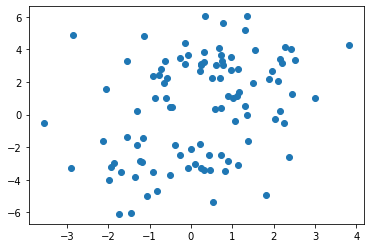

In [15]:
plt.scatter(X_test[:, 0], X_test[:, 1])

In [16]:
model.evaluate(X_test, y_test)

{'loss': 0.24042895825548719, 'accurracy': 0.94}

In [17]:
y_pred = model.predict(X_test, predict_classes=True)

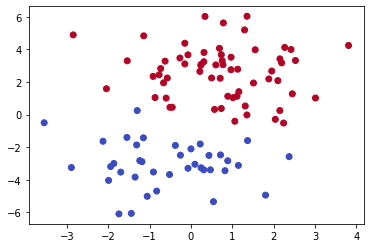

In [18]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

### Decision Boundary

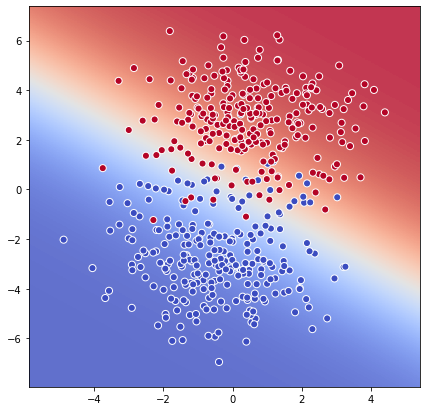

In [19]:
model.plot_decision_boundary(X, y)

---

### Generating Circular Classification Data

In [20]:
def generate_circular_data(size, classes=2, sep=5, noise=1.5, n_features=2, centre=0):
    x1 = np.linspace(-sep, sep, size // (2 * classes))
    x2 = np.sqrt(sep ** 2 - x1 ** 2) + np.random.randn(size // (2 * classes)) * (noise * sep / 10)
    X = np.r_[np.c_[x1, x2], np.c_[x1, -x2]]
    X = np.r_[X, np.random.normal(loc=centre, scale=noise, size=(size // classes, n_features))]                 
    y = np.concatenate([np.zeros(size // classes) + i for i in range(classes)], axis=0)
    return X, y

In [21]:
X, y = generate_circular_data(500)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (400, 2)
X_test shape :  (100, 2)
y_train shape :  (400,)
y_test shape :  (100,)


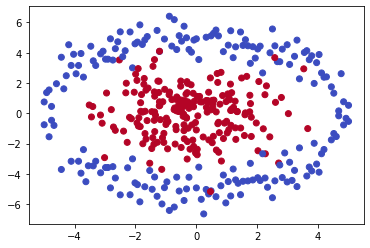

In [24]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Training

In [25]:
model = BinaryClassifier(n_features=2, degree=2)

In [26]:
model.fit(X_train, y_train, epochs=10, alpha=1)

Epoch 1/10
400/400 [==============] : loss = 1.581072	 acc = 0.3575
Epoch 2/10
400/400 [==============] : loss = 1.236275	 acc = 0.43
Epoch 3/10
400/400 [==============] : loss = 0.967892	 acc = 0.65
Epoch 4/10
400/400 [==============] : loss = 0.760338	 acc = 0.7625
Epoch 5/10
400/400 [==============] : loss = 0.599130	 acc = 0.81
Epoch 6/10
400/400 [==============] : loss = 0.475272	 acc = 0.8375
Epoch 7/10
400/400 [==============] : loss = 0.383248	 acc = 0.8675
Epoch 8/10
400/400 [==============] : loss = 0.318163	 acc = 0.885
Epoch 9/10
400/400 [==============] : loss = 0.274122	 acc = 0.9125
Epoch 10/10
400/400 [==============] : loss = 0.244657	 acc = 0.945


Text(0.5, 1.0, 'Training Accuracy')

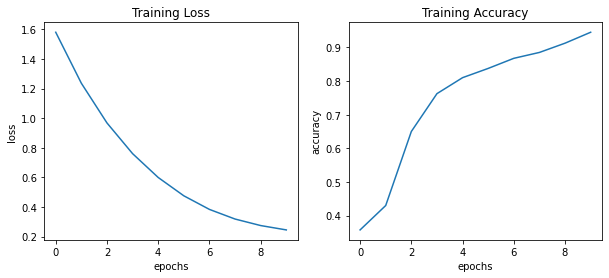

In [27]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(model.metrics['loss_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.subplot(122)
plt.plot(model.metrics['acc_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')

In [28]:
min(model.metrics['loss_per_epochs'])

0.24465723766587286

In [29]:
model.get_weights()

{'weights': array([ 0.005954, -0.027182, -0.767838, -1.980866]),
 'bias': -0.017869943301699807}

### Evaluation

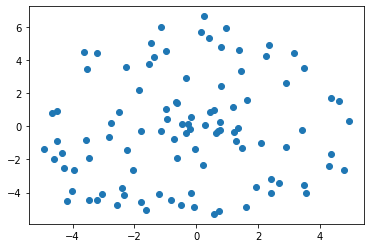

In [30]:
plt.scatter(X_test[:, 0], X_test[:, 1])

In [31]:
model.evaluate(X_test, y_test)

{'loss': 0.21774635749701027, 'accurracy': 0.98}

In [32]:
y_pred = model.predict(X_test, predict_classes=True)

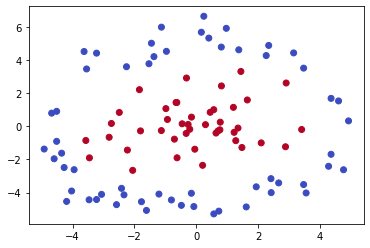

In [33]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

### Decision Boundary

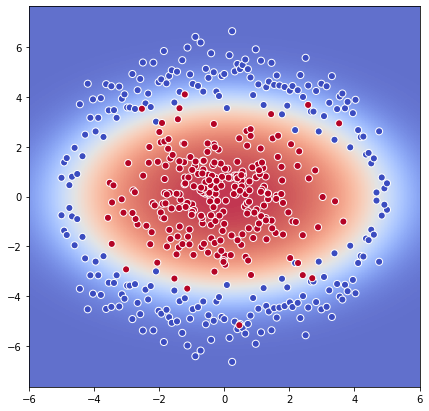

In [34]:
model.plot_decision_boundary(X, y)

---

### Generating Spiral Classification Data

In [35]:
def generate_spiral_data(n, sep=2, noise=2, centre=(0, 0)):
    size = int(n / 1.5)
    x1 = np.linspace(-sep, sep, size // 2)
    x2 = np.sqrt(sep ** 2 - x1 ** 2) + np.random.randn(size // 2) * (noise * sep / 10)
    X1 = np.r_[np.c_[x1 + centre[0], x2 + centre[1]], 
               np.c_[x1[:size // 4] + centre[0], -x2[:size // 4] + centre[1]]]
    X2 = np.r_[np.c_[x1[size // 4:] + centre[0] + sep / 2, x2[size // 4:] + centre[1] + sep / 2], 
               np.c_[x1 + centre[0] + sep / 2, -x2 + centre[1] + sep / 2]]
    X = np.r_[X1, X2]
    left = n - X.shape[0]
    if left > 0:
        X = np.r_[X, np.random.randn(left, 2) + centre]
    angle = np.random.randint(0, 181)
    theta = np.pi / 180 * angle
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    X = X @ R
    y = np.r_[np.zeros(n // 2), np.ones(n // 2)]
    return X, y

In [36]:
X, y = generate_spiral_data(500)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (400, 2)
X_test shape :  (100, 2)
y_train shape :  (400,)
y_test shape :  (100,)


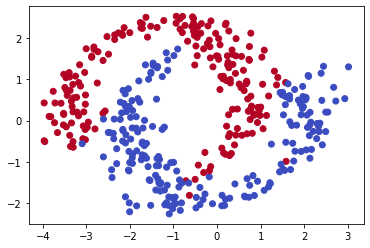

In [39]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Training

In [40]:
model = BinaryClassifier(n_features=2, degree=5)

In [41]:
model.fit(X_train, y_train, epochs=100, alpha=1)

Epoch 1/100
400/400 [==============] : loss = 0.957248	 acc = 0.6825
Epoch 2/100
400/400 [==============] : loss = 0.610522	 acc = 0.73
Epoch 3/100
400/400 [==============] : loss = 0.482316	 acc = 0.78
Epoch 4/100
400/400 [==============] : loss = 0.446810	 acc = 0.805
Epoch 5/100
400/400 [==============] : loss = 0.424535	 acc = 0.8175
Epoch 6/100
400/400 [==============] : loss = 0.407746	 acc = 0.8225
Epoch 7/100
400/400 [==============] : loss = 0.394250	 acc = 0.8225
Epoch 8/100
400/400 [==============] : loss = 0.383050	 acc = 0.8275
Epoch 9/100
400/400 [==============] : loss = 0.373558	 acc = 0.83
Epoch 10/100
400/400 [==============] : loss = 0.365376	 acc = 0.83
Epoch 11/100
400/400 [==============] : loss = 0.358215	 acc = 0.83
Epoch 12/100
400/400 [==============] : loss = 0.351864	 acc = 0.835
Epoch 13/100
400/400 [==============] : loss = 0.346165	 acc = 0.84
Epoch 14/100
400/400 [==============] : loss = 0.340997	 acc = 0.84
Epoch 15/100
400/400 [==============] : loss 

Text(0.5, 1.0, 'Training Accuracy')

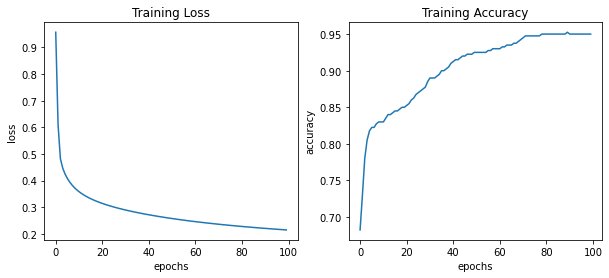

In [42]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(model.metrics['loss_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.subplot(122)
plt.plot(model.metrics['acc_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')

In [43]:
min(model.metrics['loss_per_epochs'])

0.21449866790848515

In [44]:
model.get_weights()

{'weights': array([ 1.363639,  0.471631, -2.50843 , -0.120512, -2.255295,  1.170214,
         0.360533, -0.037357, -2.940342,  1.061659]),
 'bias': 0.31978675042654825}

### Evaluation

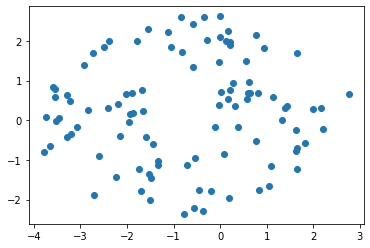

In [45]:
plt.scatter(X_test[:, 0], X_test[:, 1])

In [46]:
model.evaluate(X_test, y_test)

{'loss': 0.1892916266539621, 'accurracy': 0.96}

In [47]:
y_pred = model.predict(X_test, predict_classes=True)

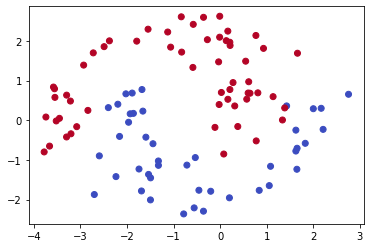

In [48]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

### Decision Boundary

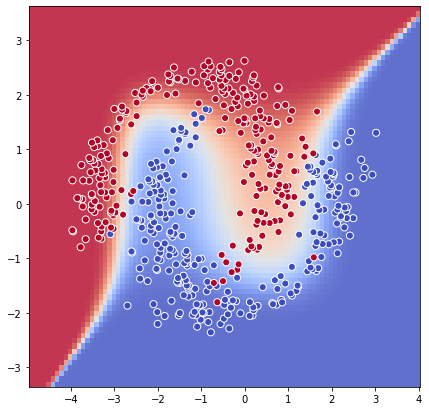

In [49]:
model.plot_decision_boundary(X, y)

---

# Multiclass Classification

In [50]:
X, y = generate_bivariate_data(1000, classes=4)

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [52]:
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (800, 2)
X_test shape :  (200, 2)
y_train shape :  (800,)
y_test shape :  (200,)


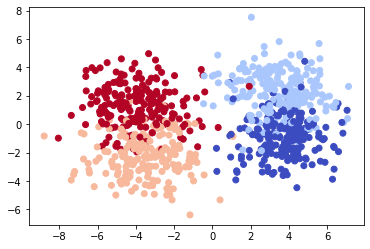

In [53]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Multiclass Logistic Regression Model

In [54]:
class MulticlassClassifier:
    def __init__(self, n_features, n_classes, degree=1, weights=None, normalize=True):
        self.__n_features = n_features
        self.__n_classes = n_classes
        self.__degree = degree
        self.__normalize = normalize
        self.__models = [BinaryClassifier(n_features=n_features, 
                                          degree=degree, 
                                          normalize=normalize) for _ in range(n_classes)]
        self.weights = weights
        self.metrics = None
            
    
    def fit(self, X, y, epochs=1, batch_size=None, alpha=0.001, verbose=True):
        loss_per_epochs, acc_per_epochs = [], []
        for i in range(epochs):
            J, acc = 0, 0
            for j in range(self.__n_classes):
                self.__models[j].fit(X, y == j, alpha=alpha, verbose=False)
            J, acc = self.evaluate(X, y).values()
            loss_per_epochs.append(J)
            acc_per_epochs.append(acc)   
            if verbose:
                print(f'Epoch {i+1}/{epochs}\n{X.shape[-1]}/{X.shape[-1]} [==============] : loss = {J:.6f}\t acc = {acc}')
        self.metrics = {'loss_per_epochs' : loss_per_epochs, 'acc_per_epochs' : acc_per_epochs}
        self.weights = np.array([model.weights for model in self.__models])
          
    def predict(self, X, predict_probs=False):
        y_pred = [None] * self.__n_classes
        for i in range(self.__n_classes):
            y_pred[i] = self.__models[i].predict(X)
        y_pred = np.c_[y_pred].T
        y_pred /= y_pred.sum(axis=1, keepdims=True)
        if not predict_probs:
            y_pred = y_pred.argsort()[:, -1]
        return y_pred
    
    def evaluate(self, X, y):
        y_pred = self.predict(X, predict_probs=True)
        y_true = tf.keras.utils.to_categorical(y)
        J = -np.sum(np.mean(y_true * np.log(y_pred + 1e-9) + (1 - y_true) * np.log(1 - y_pred + 1e-9), axis=0))
        acc = np.mean((y_pred.argsort()[:, -1] == y))
        evaluation = {'loss' : J, 'accurracy' : acc}
        return evaluation
    
    def get_weights(self):
        """returns weights as a dict object with keys - `weights` and `bias`"""
        model_weights = {'weights' : self.weights[:, 1:], 'bias' : self.weights[:, 0]}
        return model_weights 
    
    def plot_decision_boundary(self, X, y, figsize=(7,7), ec='white', s=50,alpha=0.8):
        plt.figure(figsize=figsize)
        x1 = np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, 0.1)
        x2 = np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, 0.1)

        X1, X2 = np.meshgrid(x1, x2)
        X1, X2 = X1.ravel(), X2.ravel() 
        preds = model.predict(np.c_[X1, X2]).reshape(x2.shape[0], x1.shape[0])

        extent=[X[:, 0].min() - 1, X[:, 0].max() + 1, X[:, 1].min() - 1, X[:, 1].max() + 1]
        plt.imshow(preds, origin='lower', extent=extent, alpha=alpha, aspect='auto')
        plt.scatter(X[:, 0], X[:, 1], c=y, ec=ec, s=s)

In [55]:
model = MulticlassClassifier(n_features=2, n_classes=4, degree=2)

In [56]:
model.fit(X, y, epochs=200, alpha=1)

Epoch 1/200
2/2 [==============] : loss = 2.001614	 acc = 0.414
Epoch 2/200
2/2 [==============] : loss = 1.868184	 acc = 0.475
Epoch 3/200
2/2 [==============] : loss = 1.738882	 acc = 0.568
Epoch 4/200
2/2 [==============] : loss = 1.619264	 acc = 0.644
Epoch 5/200
2/2 [==============] : loss = 1.514221	 acc = 0.71
Epoch 6/200
2/2 [==============] : loss = 1.426193	 acc = 0.76
Epoch 7/200
2/2 [==============] : loss = 1.354534	 acc = 0.784
Epoch 8/200
2/2 [==============] : loss = 1.296640	 acc = 0.795
Epoch 9/200
2/2 [==============] : loss = 1.249493	 acc = 0.799
Epoch 10/200
2/2 [==============] : loss = 1.210503	 acc = 0.807
Epoch 11/200
2/2 [==============] : loss = 1.177702	 acc = 0.824
Epoch 12/200
2/2 [==============] : loss = 1.149653	 acc = 0.831
Epoch 13/200
2/2 [==============] : loss = 1.125311	 acc = 0.838
Epoch 14/200
2/2 [==============] : loss = 1.103913	 acc = 0.843
Epoch 15/200
2/2 [==============] : loss = 1.084888	 acc = 0.844
Epoch 16/200
2/2 [==============] : 

Epoch 152/200
2/2 [==============] : loss = 0.715721	 acc = 0.865
Epoch 153/200
2/2 [==============] : loss = 0.715218	 acc = 0.866
Epoch 154/200
2/2 [==============] : loss = 0.714720	 acc = 0.866
Epoch 155/200
2/2 [==============] : loss = 0.714228	 acc = 0.866
Epoch 156/200
2/2 [==============] : loss = 0.713741	 acc = 0.867
Epoch 157/200
2/2 [==============] : loss = 0.713260	 acc = 0.867
Epoch 158/200
2/2 [==============] : loss = 0.712784	 acc = 0.867
Epoch 159/200
2/2 [==============] : loss = 0.712313	 acc = 0.867
Epoch 160/200
2/2 [==============] : loss = 0.711848	 acc = 0.867
Epoch 161/200
2/2 [==============] : loss = 0.711387	 acc = 0.867
Epoch 162/200
2/2 [==============] : loss = 0.710931	 acc = 0.867
Epoch 163/200
2/2 [==============] : loss = 0.710481	 acc = 0.866
Epoch 164/200
2/2 [==============] : loss = 0.710035	 acc = 0.866
Epoch 165/200
2/2 [==============] : loss = 0.709593	 acc = 0.866
Epoch 166/200
2/2 [==============] : loss = 0.709157	 acc = 0.866
Epoch 167/

In [57]:
model.predict(X)

array([0, 0, 0, ..., 3, 3, 3])

In [58]:
model.evaluate(X, y)

{'loss': 0.6966284219694653, 'accurracy': 0.867}

In [59]:
model.get_weights()

{'weights': array([[ 3.7803  , -2.336349, -0.894839, -0.909942],
        [ 2.947804,  2.759191, -0.947625, -0.237176],
        [-3.049381, -2.757024, -1.124965, -0.294334],
        [-3.598634,  2.535349, -0.729445, -1.1333  ]]),
 'bias': array([-3.590517, -3.676777, -3.729844, -3.434827])}

Text(0.5, 1.0, 'Training Accuracy')

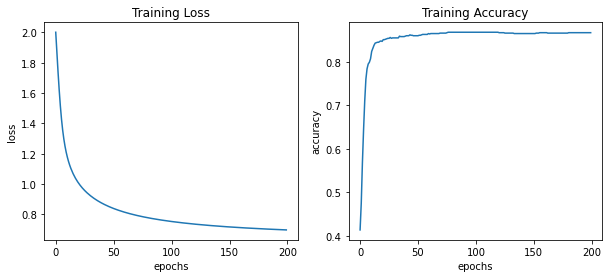

In [60]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(model.metrics['loss_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.subplot(122)
plt.plot(model.metrics['acc_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')

### Evaluation

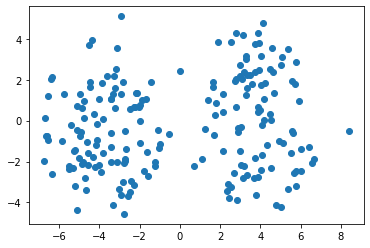

In [61]:
plt.scatter(X_test[:, 0], X_test[:, 1])

In [62]:
model.evaluate(X_test, y_test)

{'loss': 0.7536664158243083, 'accurracy': 0.87}

In [63]:
y_pred = model.predict(X_test)

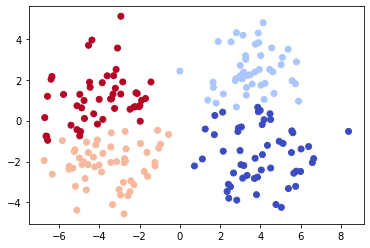

In [64]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

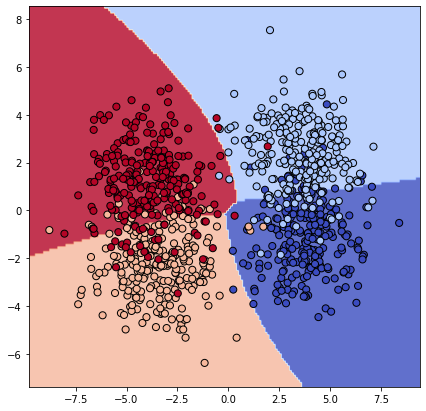

In [65]:
model.plot_decision_boundary(X, y, ec='k')